<a href="https://colab.research.google.com/github/itonito/Coursera_Capstone/blob/master/Final_AppliedDataScienceCapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import getpass
import requests 
import random
import folium
import matplotlib.pyplot as plt

from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
from urllib import request
from folium.plugins import HeatMap

In [0]:
ll_df = pd.read_csv('http://cocl.us/Geospatial_data')

In [0]:
def load_traffic_data():
  #url
  url = "https://www.toronto.ca/ext/open_data/catalog/data_set_files/2015%20Subway%20Platform%20Usage%20Open%20Data%20Toronto.xlsx"
  traffic_df = pd.read_excel(url,header=3,  index_col=0, usecols=[0,1,2,3,4])
  return traffic_df.dropna()


In [0]:
subway_traffic_df = load_traffic_data()
subway_traffic_df.columns = ['Station', 'To', 'From', 'Totals']
subway_traffic_df['Station'] = subway_traffic_df['Station'].str.replace(r"\(.*\)","")
subway_traffic_df = subway_traffic_df.astype({"To": int, "From": int, "Totals": int})
subway_traffic_df.head()
sum_df = subway_traffic_df.groupby("Station", as_index=False)['Totals'].sum()

In [0]:
def load_geolocation(url):
  # read csv
  geo_df = pd.read_csv(url, names = ["Latitude", "Longitude", "Station"])
  return geo_df.dropna()

In [0]:
bloor_df = load_geolocation("http://scruss.com/wordpress/wp-content/bloor-danforth-NAD83.csv")
younge_df = load_geolocation("http://scruss.com/wordpress/wp-content/yonge-university-spadina-NAD83.csv")
sheppard_df = load_geolocation("http://scruss.com/wordpress/wp-content/sheppard-yonge-NAD83.csv")
scarborough_df = load_geolocation("http://scruss.com/wordpress/wp-content/srt-NAD83.csv")
locations_df = pd.concat([bloor_df, younge_df,sheppard_df,scarborough_df]).reset_index(drop=True)

In [0]:
traffic_n_geo = pd.merge(locations_df, sum_df, on='Station')
traffic_n_geo = traffic_n_geo.astype({"Totals": int})
stations_traffic_df = traffic_n_geo

In [0]:
def num_stores(LON, LAT, CATEGORY, CLIENT_ID, CLIENT_SECRET):
    VERSION = '20180604'
    LIMIT = 50
    search_query = ''
    radius = 130
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, LAT, LON, VERSION, search_query, radius, LIMIT, CATEGORY)
    results = requests.get(url).json()
    return len(results['response']['venues'])

In [0]:
# iterate through all rows in stations_traffic_df and add the number of stores by running num_stores()
CLIENT_ID = api_key = 'AQKRZCVNYE4D5UHTOZRTAAUYIYZRJA1CHG55JDPULE155OQL' #getpass.getpass("Client ID: ") 
CLIENT_SECRET = 'N420RKFJGD4TH0Z2VY0SRHL1QN02A2O2FXKRSUAPM00H2CYF' #getpass.getpass("Client Secret: ") 
num_store_list = []
for i, row in stations_traffic_df.iterrows():
      latx = stations_traffic_df.at[i,'Latitude']
      lonx = stations_traffic_df.at[i,'Longitude'] 
      stores = num_stores(lonx, latx, '4bf58dd8d48988d103951735', CLIENT_ID, CLIENT_SECRET)
      num_store_list.append(stores)
stations_traffic_df['Stores'] = num_store_list

In [0]:
ratio_df = stations_traffic_df
ratio_df['Totals'] = ratio_df['Totals'] / ratio_df['Totals'].max()
ratio_df['Stores'] = ratio_df['Stores'] / ratio_df['Stores'].max()

In [0]:
np.set_printoptions(precision=10, suppress=True)

a_traffic  = np.array
a_traffic = ratio_df[['Latitude', 'Longitude', 'Totals']].values

a_stores  = np.array
a_stores = ratio_df[['Latitude', 'Longitude', 'Stores']].values

In [121]:
traffic_map = folium.Map(location=[43.703908, -79.384293], zoom_start=12)
traffic_map.add_child(HeatMap(a_traffic,  max_val=0.01))
folium.Marker([43.781490, -79.415673], popup='Finch', icon=folium.Icon(color='blue')).add_to(traffic_map)
folium.Marker([43.638020, -79.536388], popup='Kipling', icon=folium.Icon(color='blue')).add_to(traffic_map)
folium.Marker([43.750054, -79.462343], popup='Downsview', icon=folium.Icon(color='blue')).add_to(traffic_map)
folium.Marker([43.775565, -79.346936], popup='Don Mills', icon=folium.Icon(color='blue')).add_to(traffic_map)
folium.Marker([43.706646, -79.399158], popup='Eglinton', icon=folium.Icon(color='blue')).add_to(traffic_map)
traffic_map

In [112]:
store_map = folium.Map(location=[43.703908, -79.384293], zoom_start=12)
store_map.add_child(HeatMap(a_stores,  max_val=0.01))

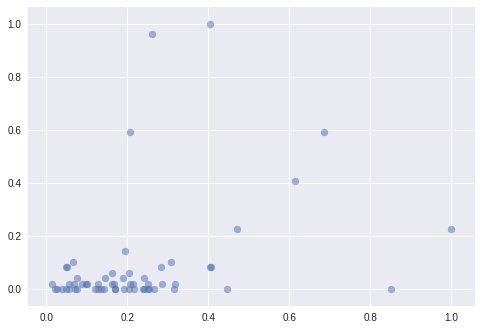

In [116]:
y  = stations_traffic_df['Stores'].tolist()
x  = stations_traffic_df['Totals'].tolist()

plt.scatter(x, y, alpha=0.5)
plt.show()

In [0]:
non_zero_stores = stations_traffic_df.loc[stations_traffic_df['Stores'] != 0]


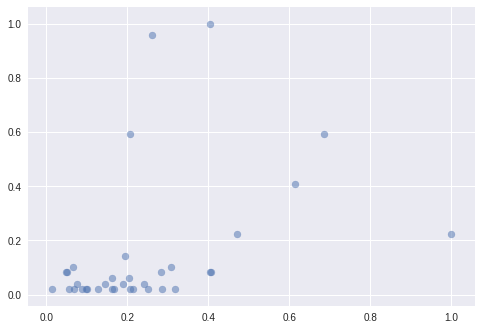

In [0]:
y  = non_zero_stores['Stores'].tolist()
x  = non_zero_stores['Totals'].tolist()

plt.scatter(x, y, alpha=0.5)
plt.show()

In [117]:
non_zero_stores.head()

,Latitude,Longitude,Station,Totals,Stores,People per Store
0,43.750054,-79.462343,Downsview,37670,1,37670
1,43.775565,-79.346936,Don Mills,33756,1,33756
2,43.657142,-79.452678,Dundas West,29617,1,29617
3,43.698123,-79.397331,Davisville,25328,1,25328
4,43.725422,-79.401878,Lawrence,24555,1,24555


In [0]:
non_zero_stores = non_zero_stores.astype({"People per Store": int})
non_zero_stores = non_zero_stores.sort_values(by='People per Store', ascending=False).reset_index(drop=True)

In [119]:
non_zero_stores.head()

,Latitude,Longitude,Station,Totals,Stores,People per Store
0,43.750054,-79.462343,Downsview,37670,1,37670
1,43.775565,-79.346936,Don Mills,33756,1,33756
2,43.657142,-79.452678,Dundas West,29617,1,29617
3,43.698123,-79.397331,Davisville,25328,1,25328
4,43.725422,-79.401878,Lawrence,24555,1,24555


In [0]:
zero_stores = stations_traffic_df.loc[stations_traffic_df['Stores'] == 0]
zero_stores = zero_stores.sort_values(by='Totals', ascending=False).reset_index(drop=True)
zero_stores.head()

,Latitude,Longitude,Station,Totals,Stores
0,43.781490,-79.415673,Finch,100819,0
1,43.638020,-79.536388,Kipling,52925,0
2,43.645950,-79.523948,Islington,37412,0
3,43.662663,-79.426157,Ossington,31614,0
4,43.660665,-79.435956,Dufferin,29937,0
